# Vanilla ResNet-18 Implementation

All code below are based from https://github.com/a-martyn/resnet/blob/master/resnet.py

Import necessary dependencies

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

import warnings
warnings.filterwarnings('ignore')

## Preprocess

In [24]:
data_dir = '../data/'
transform = transforms.Compose([
    transforms.ToTensor(),
    # do not flatten for CNN
    ])

batch_size = 128

In [28]:
# load / dataload CIFAR-10 dataset


# !TODO: skipped augmentation (such as RandomFlip, RandomCrop, etc.)

def get_data_loaders(data_dir,
                     batch_size,
                     transform,
                     shuffle_train=True,
                     shuffle_test=False,
                     num_workers=4,
                     pin_memory=True):
    train_dataset = datasets.CIFAR10(
        root=data_dir,
        train=True,
        download=True,
        transform=transform,
    )

    test_dataset = datasets.CIFAR10(
        root=data_dir,
        train=False,
        download=True,
        transform=transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=shuffle_test,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    return train_loader, test_loader

train_loader, test_loader = get_data_loaders(
    data_dir,
    batch_size,
    transform
)
    

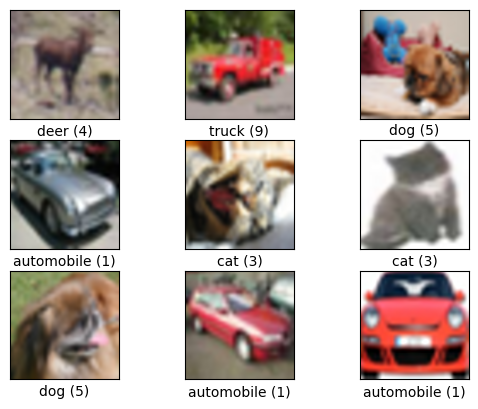

torch.Size([128, 3, 32, 32])


In [29]:
def plot_images(images, cls_true, cls_pred=None):
    """
    Plot images with labels.
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    
    # CIFAR10 labels
    label_names = [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'
    ]
    
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


data_iter = iter(train_loader)
images, labels = next(data_iter)
X = images.numpy().transpose(0, 2, 3, 1)
plot_images(X, labels)
print(images.shape)

In [30]:
train_loader, test_loader = get_data_loaders(
                                            data_dir,
                                            batch_size,
                                            transform,
                                            num_workers=4,
                                            pin_memory=True
                                        )

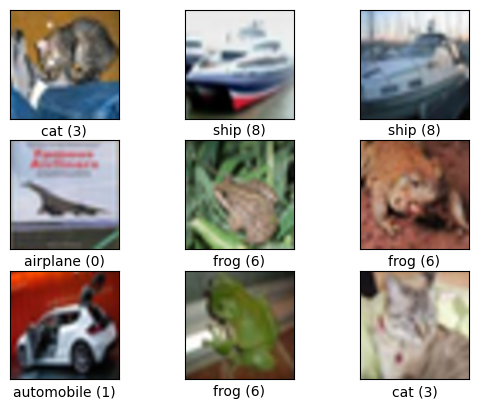

torch.Size([128, 3, 32, 32])


In [31]:
data_iter_test = iter(test_loader)
images_test, labels_test = next(data_iter_test)
X_test = images_test.numpy().transpose(0, 2, 3, 1)
plot_images(X_test, labels_test)
print(images_test.shape)

## Training

In [32]:
iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations += 1
print(iterations)

391


### Setting Hyperparameters

In [33]:
epochs = round(64000 / iterations) # 164
print(f"epochs: {epochs}")
lr = 0.1
momentum = 0.9
# !TODO: didn't implement weight decay for now

# !TODO: didn't implement learning rate scheduler/adjustment for now

epochs: 164


## Define Neural Network Model

### Plain Nets

In [34]:
class block(nn.Module):
    """
    A fundamental building block for ResNet Structures, which inclues:
    - two convolutional layers each followed by batch normalization and ReLU activation
    - a shortcut connection that adds the input to the output, with subsampling if needed
    Initial codes are from https://github.com/a-martyn/resnet/blob/master/resnet.py
    """
    def __init__(self, filters, subsample=False):
        super(block, self).__init__()
        # s = stride
        # z becomes half the size of x when subsample = True
        s = 0.5 if subsample else 1.0
        
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3,
                               stride=int(1/s), padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2d = nn.Conv2d(filters, filters, kernel_size=3, stride=1,
                                padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()

        # shortcut subsample
        # this is a mechanism used when the input to the residual block x has different dimensions (either spatial size or number of channels)
        # than the output of the convolutional layers z.
        # instead of pooling we use stride which makes learned subsampling possible.
        self.subsample = nn.AvgPool2d(kernel_size=1, stride=2)

        # weight initialization based on Kaiming He et al., "Delving Deep into Rectifiers: 
        # Surpassing Human-Level Performance on ImageNet Classification"
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # calculate variance based on output channels
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def shortcut(self, z, x):
        """
        shortcut connection using identity or subsampling
        """

        # x.shape: (batch_size, C, H, W)
        # z.shape: (batch_size, 2 * C, 1/2 * H, 1/2 * W)
        # Thus we need to subsample x to match 1/2 * H, 1/2 * W 
        # and pad channels with zeros to match 2 * C
        if x.shape != z.shape:
            # reduces the spatial dimensions of x by half using stride 2 pooling
            d = self.subsample(x)
            # pads the channel dimension with zeros to match z's channels
            p = torch.mul(d, 0)
            # shape matches: (batch_size, 2 * C, 1/2 * H, 1/2 * W) so we can add
            return z + torch.cat((d, p), dim=1)
        else:
            return z + x
        
    
    def forward(self, x, shortcuts=False):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        z = self.conv2d(z)
        z = self.bn2(z)

        if shortcuts:
            z = self.shortcut(z, x)

        z = self.relu2(z)
        return z

In [35]:
class ResNet(nn.Module):
    """
    A general ResNet model.
    Initial codes are from https://github.com/a-martyn/resnet/blob/master/resnet.py
    
    Args:
        n: number of blocks per stack
        shortcuts: whether to use shortcut connections

    Returns:
        output: log-probabilities for each class
    """
    def __init__(self, n, shortcuts=True):
        super().__init__()
        self.shortcuts = shortcuts

        # spatial size is kept the same because of padding=1 and kernel_size=3
        # (B, 3, 32, 32) --> (B, 16, 32, 32)
        self.convIn = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnIn = nn.BatchNorm2d(16, track_running_stats=True)
        self.relu = nn.ReLU()

        # 16 channels with NO subsampling; repeat n times
        # (B, 16, 32, 32) --> (B, 16, 32, 32)
        self.stack1 = nn.ModuleList([block(16, subsample=False) for _ in range(n)])
        
        # double the channels with subsampling
        # (B, 16, 32, 32) --> (B, 32, 16, 16)
        self.stack2a = block(32, subsample=True)

        # 32 channels with NO subsampling(keep the H, W same); repeat n-1 times
        # (B, 32, 16, 16) --> (B, 32, 16, 16)
        self.stack2b = nn.ModuleList([block(32, subsample=False) for _ in range(n-1)])
        
        # double the channels with subsampling
        # (B, 32, 16, 16) --> (B, 64, 8, 8)
        self.stack3a = block(64, subsample=True)
        # 64 channels with NO subsampling(keep the H, W same); repeat n-1 times
        # (B, 64, 8, 8) --> (B, 64, 8, 8)
        self.stack3b = nn.ModuleList([block(64, subsample=False) for _ in range(n-1)])

        # global average pooling and output layer
        # (B, 64, 8, 8) --> (B, 64, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # final fully connected layer
        self.fcOut = nn.Linear(64, 10, bias=True)
        # log-softmax to predict log-probabilities for each class
        self.softmax = nn.LogSoftmax(dim=-1)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight)
                m.bias.data.zero_()

    def forward(self, x):
        z = self.convIn(x)
        z = self.bnIn(z)
        z = self.relu(z)

        for l in self.stack1:
            z = l(z, shortcuts=self.shortcuts)
        z = self.stack2a(z, shortcuts=self.shortcuts)
        for l in self.stack2b:
            z = l(z, shortcuts=self.shortcuts)
        z = self.stack3a(z, shortcuts=self.shortcuts)
        for l in self.stack3b:
            z = l(z, shortcuts=self.shortcuts)
        
        z = self.avgpool(z)
        # flatten
        z = z.view(z.size(0), -1)
        z = self.fcOut(z)
        return self.softmax(z)


In [36]:
import glob


def evaluate(model, data_loader, device):

    y_true = np.array([], dtype=int)
    y_pred = np.array([], dtype=int)

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true = np.concatenate((y_true, labels.cpu()))
            y_pred = np.concatenate((y_pred, predicted.cpu()))

    error = np.sum(y_pred != y_true) / len(y_true)
    return error


def train(model, epochs, train_loader, test_loader, criterion, optimizer,
          RESULTS_PATH, MODEL_PATH=None):
    # set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # create results dataframe or load existing
    cols = ['epoch', 'train_loss', 'train_err', 'test_err']
    if os.path.exists(RESULTS_PATH):
        results_df = pd.read_csv(RESULTS_PATH, index_col='epoch')
        start_epoch = len(results_df)  # start from the next epoch
    else:
        results_df = pd.DataFrame(columns=cols).set_index('epoch')
        start_epoch = 0

    # check for existing checkpoints (priority: checkpoint files > best model file)
    checkpoint_loaded = False
    if MODEL_PATH:
        base_name = MODEL_PATH.replace('.pt', '')
        checkpoint_pattern = f"{base_name}_epoch_*.pt"
        checkpoint_files = glob.glob(checkpoint_pattern)
        
        if checkpoint_files:
            # Load from checkpoint file (has optimizer state)
            epochs_in_files = [int(f.split('_epoch_')[-1].replace('.pt', '')) for f in checkpoint_files]
            max_epoch = max(epochs_in_files)
            latest_checkpoint = f"{base_name}_epoch_{max_epoch}.pt"
            print(f"Loading checkpoint from {latest_checkpoint}")
            checkpoint = torch.load(latest_checkpoint, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_test_err = checkpoint['test_err']
            checkpoint_loaded = True
            # load results_df up to max_epoch if not already loaded
            if len(results_df) <= max_epoch:
                results_df = results_df.reindex(range(max_epoch + 1))
                results_df.loc[max_epoch] = [checkpoint['train_loss'], checkpoint['train_err'], checkpoint['test_err']]
        elif os.path.exists(MODEL_PATH):
            # Load from best model file (only has model weights)
            print(f"Loading best model weights from {MODEL_PATH} (no optimizer state)")
            model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
            best_test_err = results_df['test_err'].min() if len(results_df) > 0 else 1.0
            checkpoint_loaded = True
        else:
            best_test_err = 1.0
    else:
        best_test_err = 1.0
    
    if checkpoint_loaded:
        print(f"Resuming training from epoch {start_epoch}")
    
    print(f'Training on device: {device}')
    print('Epoch \tBatch \tNLLLoss_Training')

    for epoch in range(start_epoch, epochs):
        model.train()
        # cumulative loss for printing
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 50 == 49:    # print every 50 mini-batches
                print(f'{epoch + 1} \t{i + 1} \t{running_loss / 50:.3f}')
                running_loss = 0.0
        
        model.eval()
        train_loss = loss.item()
        train_err = evaluate(model, train_loader, device)
        test_err = evaluate(model, test_loader, device)

        results_df.loc[epoch] = [train_loss, train_err, test_err]
        results_df.to_csv(RESULTS_PATH)
        print(f"Epoch {epoch + 1}: train_err = {train_err:.4f}, test_err = {test_err:.4f}")

        # Save checkpoint every 30 epochs
        if MODEL_PATH and (epoch + 1) % 30 == 0:
            base_name = MODEL_PATH.replace('.pt', '')
            intermediate_model_path = f"{base_name}_epoch_{epoch}.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_err': train_err,
                'test_err': test_err
            }, intermediate_model_path)
            print(f"Checkpoint saved: {intermediate_model_path}")

        # Save best model (only model weights)
        if MODEL_PATH and (test_err < best_test_err):
            torch.save(model.state_dict(), MODEL_PATH)
            best_test_err = test_err
            print(f"New best model saved: {MODEL_PATH} (test_err = {test_err:.4f})")


### Training a Plain CNN (6 * 3 + 2 = 20)

In [37]:
n = 3
# We are not trying to use ResNet here.
# since vanilla CNN is ResNet without shortcuts,
# we are just reusing the ResNet class with shortcuts=False
model = ResNet(n, shortcuts=False)
criterion = torch.nn.NLLLoss()
#!TODO: didn't implement weight decay for now
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#!TODO: didn't implement learning rate scheduler/adjustment for now
results_file = f'results_resnet_plainnet{6*n+2}.csv'
model_file = f'model_resnet_plainnet{6*n+2}.pt'

train(model, epochs, train_loader, test_loader, criterion,
        optimizer, results_file, MODEL_PATH=model_file)

Loading best model weights from model_resnet_plainnet20.pt (no optimizer state)
Resuming training from epoch 164
Training on device: cuda
Epoch 	Batch 	NLLLoss_Training


### Training a ResNet

In [41]:
print("Model size: n =", n, ", layers =", 6*n+2)

train_loader, test_loader = get_data_loaders(data_dir,
                                            batch_size,
                                            transform,
                                            num_workers=4,
                                            pin_memory=True
                                        )
model = ResNet(n, shortcuts=True)
criterion = torch.nn.NLLLoss()
# !TODO: weighted decay not implemented for now
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# !TODO: learning rate scheduler/adjustment not implemented for now
results_file = f'results_resnet_resnet{6*n+2}.csv'
model_file = f'model_resnet_resnet{6*n+2}.pt'
train(model, epochs, train_loader, test_loader, criterion,
        optimizer, results_file, MODEL_PATH=model_file)

print("Train Finished for ResNet: n =", n, ", layers =", 6*n+2)

Model size: n = 3 , layers = 20
Training on device: cuda
Epoch 	Batch 	NLLLoss_Training
1 	50 	2.174
1 	100 	1.670
1 	150 	1.558
1 	200 	1.444
1 	250 	1.372
1 	300 	1.272
1 	350 	1.233
Epoch 1: train_err = 0.4795, test_err = 0.4904
New best model saved: model_resnet_resnet20.pt (test_err = 0.4904)
2 	50 	1.100
2 	100 	1.057
2 	150 	1.004
2 	200 	0.985
2 	250 	0.952
2 	300 	0.914
2 	350 	0.903
Epoch 2: train_err = 0.3366, test_err = 0.3516
New best model saved: model_resnet_resnet20.pt (test_err = 0.3516)
3 	50 	0.799
3 	100 	0.779
3 	150 	0.801
3 	200 	0.764
3 	250 	0.765
3 	300 	0.744
3 	350 	0.722
Epoch 3: train_err = 0.2329, test_err = 0.2672
New best model saved: model_resnet_resnet20.pt (test_err = 0.2672)
4 	50 	0.639
4 	100 	0.676
4 	150 	0.662
4 	200 	0.638
4 	250 	0.630
4 	300 	0.615
4 	350 	0.613
Epoch 4: train_err = 0.2097, test_err = 0.2479
New best model saved: model_resnet_resnet20.pt (test_err = 0.2479)
5 	50 	0.523
5 	100 	0.542
5 	150 	0.567
5 	200 	0.550
5 	250 	0.537

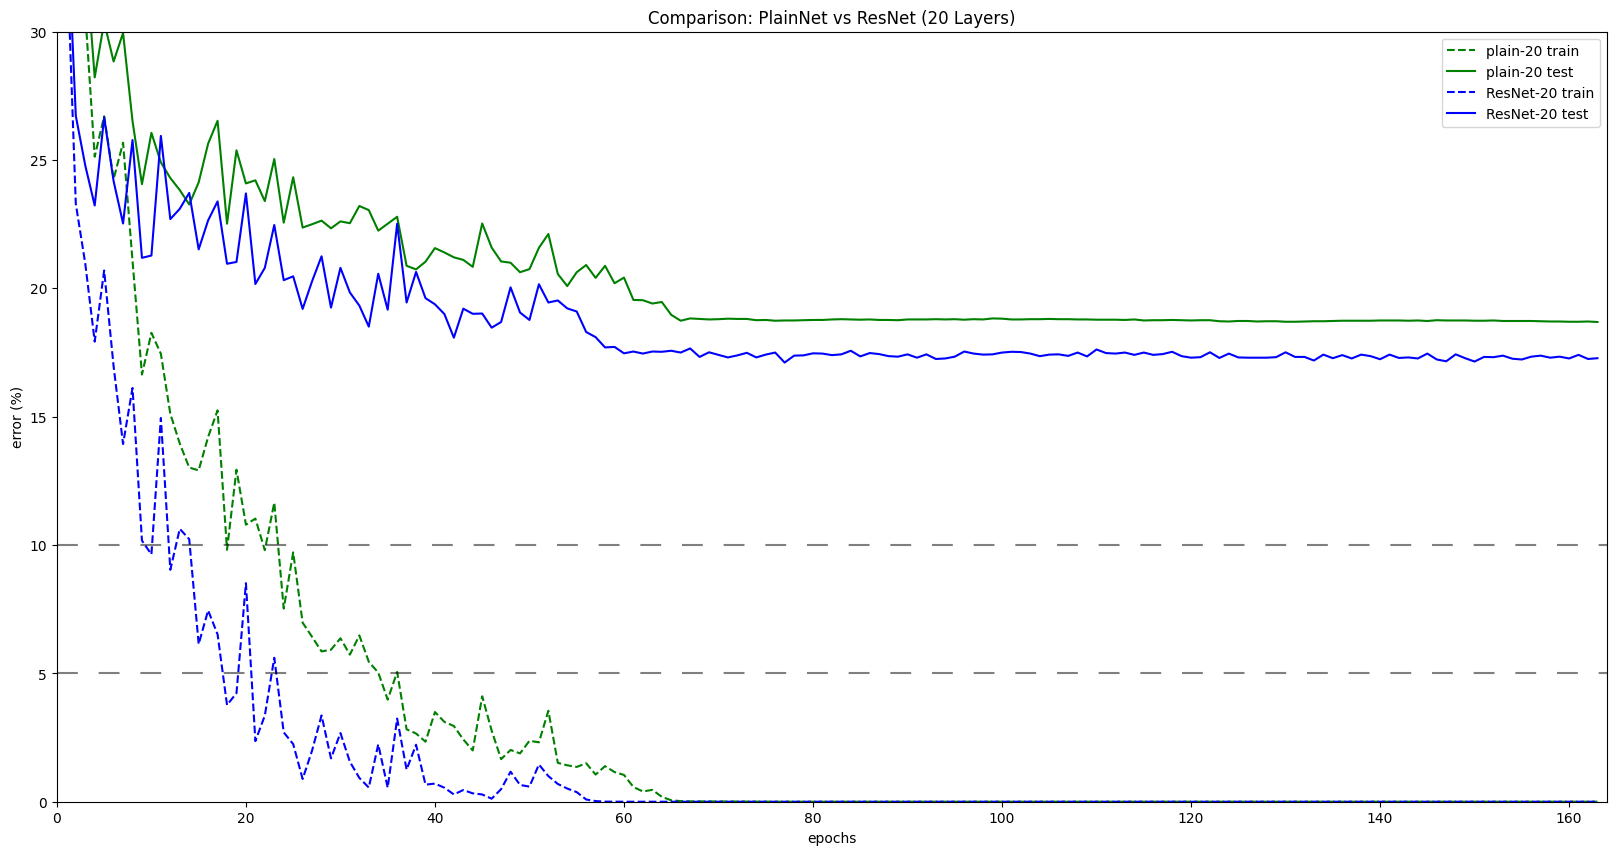

In [43]:
n = 3

# Read both result files
plainnet_df = pd.read_csv(f'results_resnet_plainnet{6*n+2}.csv')
resnet_df = pd.read_csv(f'results_resnet_resnet{6*n+2}.csv')

# Create single figure with both plots
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 30])

# Plot PlainNet
plt.plot(plainnet_df['epoch'], plainnet_df['train_err']*100, 'g--',
            label=f'plain-{6*n+2} train')
plt.plot(plainnet_df['epoch'], plainnet_df['test_err']*100, 'g',
            label=f'plain-{6*n+2} test')

# Plot ResNet
plt.plot(resnet_df['epoch'], resnet_df['train_err']*100, 'b--',
            label=f'ResNet-{6*n+2} train')
plt.plot(resnet_df['epoch'], resnet_df['test_err']*100, 'b',
            label=f'ResNet-{6*n+2} test')

plt.title('Comparison: PlainNet vs ResNet (20 Layers)')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.))
plt.show()